# Cat, Dog 분류(prtial) - CNN ver2
- partial data (부분 데이터)
  - train data: dog 1000, cat 1000
  - test data: dog 500, cat 500
- image centering O

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2022-05-24 08:41:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.132.128, 173.194.197.128, 173.194.192.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.132.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   167MB/s    in 0.4s    

2022-05-24 08:41:53 (167 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
# zip 파일 풀기
!unzip cats_and_dogs_filtered.zip > /dev/null

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

1. 데이터 탐색  

In [4]:
# 이미지 축소/확대 및 센터링 
IMAGE_SIZE = 150

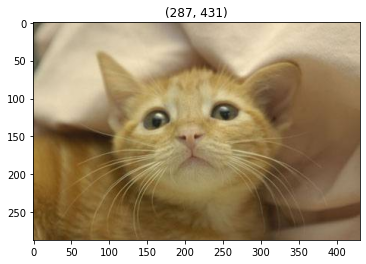

In [5]:
import cv2
fname = 'cats_and_dogs_filtered/train/cats/cat.475.jpg'
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(img), plt.title(img.shape[:-1]);

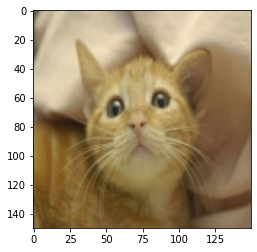

In [6]:
plt.imshow(cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA));

In [7]:
h, w, _ = img.shape
h, w

(287, 431)

In [8]:
if h > w:
    width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
else:
    width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

In [9]:
# Pillow image: new_img = np.array(img.resize((width, height)))
new_img = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_AREA)
new_img.shape

(150, 225, 3)

In [10]:
diff = abs(width - height) // 2

In [11]:
if h > w:
    final_img = new_img[diff:diff+IMAGE_SIZE, :]
else:
    final_img = new_img[:, diff:diff+IMAGE_SIZE]

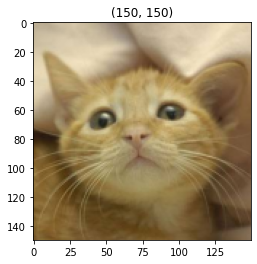

In [12]:
plt.imshow(final_img), plt.title(final_img.shape[:-1]);

In [16]:
from PIL import Image
def center_image(img, src_format='OpenCV', dst_format='OpenCV'):
    if src_format == 'OpenCV':
        h, w = img.shape[:-1]
    else:                       # Pillow
        h, w = np.array(img).shape[:-1]

    if h > w:
        width, height = IMAGE_SIZE, (h * IMAGE_SIZE) // w
    else:
        width, height = (w * IMAGE_SIZE) // h, IMAGE_SIZE

    interpolation = cv2.INTER_AREA if h + w > 300 else cv2.INTER_CUBIC
    new_img = cv2.resize(img, dsize=(width, height), interpolation=interpolation)

    diff = abs(width - height) // 2
    if h > w:
        final_img = new_img[diff:diff+IMAGE_SIZE, :]
    else:
        final_img = new_img[:, diff:diff+IMAGE_SIZE]

    return final_img if dst_format == 'OpenCV' else Image.fromarray(final_img)

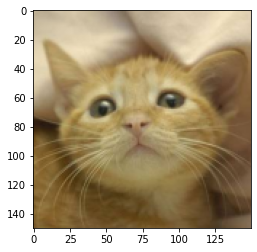

In [17]:
img = cv2.imread(fname)[:,:,::-1]
plt.imshow(center_image(img));

2. 파일에서 센터 이미지로 변환해서 저장 

In [18]:
CENTER_DIR = 'cats_and_dogs_centered'
train_dir = f'{CENTER_DIR}/train'
validation_dir = f'{CENTER_DIR}/validation'
train_cats_dir = f'{CENTER_DIR}/train/cats'
train_dogs_dir = f'{CENTER_DIR}/train/dogs'
validation_cats_dir = f'{CENTER_DIR}/validation/cats'
validation_dogs_dir = f'{CENTER_DIR}/validation/dogs'

In [19]:
import os
if not os.path.exists(CENTER_DIR):
    os.mkdir(CENTER_DIR)
for dir in [train_dir,validation_dir,train_cats_dir,train_dogs_dir,validation_cats_dir,validation_dogs_dir]:
    os.mkdir(dir)

In [20]:
old_train_cats_dir = 'cats_and_dogs_filtered/train/cats'
old_train_dogs_dir = 'cats_and_dogs_filtered/train/dogs'
old_validation_cats_dir = 'cats_and_dogs_filtered/validation/cats'
old_validation_dogs_dir = 'cats_and_dogs_filtered/validation/dogs'

In [22]:
# cats_and_dogs_filtered --> image 축소/확대 후 centering --> cats_and_dogs_centered
from glob import glob

for src_dir in [old_train_cats_dir, old_train_dogs_dir, old_validation_cats_dir, old_validation_dogs_dir]:
  # 방법 1
  #dst_dir = src_dir.split('/')[1:]
  #dst_dir = '/'.join([CENTER_DIRT] + dst_dir)

  # 방법 2
  dst_dir = src_dir.replace('filtered', 'centered')
  for fname in glob(f'{src_dir}/*.jpg'):
    dst_fname = fname.split('/')[-1] # -> cat.475.jpg
    src_img = cv2.imread(fname)[:,:,::-1]
    dst_img = center_image(src_img, src_format='OpenCV', dst_format='Pillow')
    dst_img.save(f'{dst_dir}/{dst_fname}')


In [23]:
# 파일 이름
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)

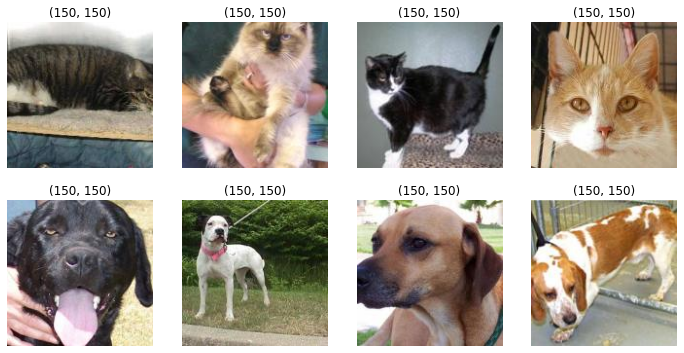

In [24]:
plt.figure(figsize=(12,6))
for i in range(4):
    plt.subplot(2, 4, i+1)
    cat = cv2.imread(os.path.join(train_cats_dir, train_cats_fnames[i]))[:,:,::-1]
    plt.imshow(cat), plt.axis('off'), plt.title(cat.shape[:-1])
    plt.subplot(2, 4, i+5)
    dog = cv2.imread(os.path.join(train_dogs_dir, train_dogs_fnames[i]))[:,:,::-1]
    plt.imshow(dog), plt.axis('off'), plt.title(dog.shape[:-1])
plt.show()

모델 구성 및 학습

In [25]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [26]:
model = Sequential([ 
    Conv2D(16, (3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [27]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-8),
    loss='binary_crossentropy', metrics=['accuracy']
)

In [28]:
model_path = 'best-cats-and-dogs-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [30]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    validation_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [31]:
hist = model.fit(
    train_generator, 
    validation_data=test_generator,
    epochs=100, steps_per_epoch=100,
    validation_steps=50, callbacks=[mc, es]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.5600
Epoch 1: val_loss improved from inf to 0.65651, saving model to best-cats-and-dogs-v2.h5
100/100 [==============================] - 59s 572ms/step - loss: 0.8897 - accuracy: 0.5600 - val_loss: 0.6565 - val_accuracy: 0.6350
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.6315
Epoch 2: val_loss improved from 0.65651 to 0.64174, saving model to best-cats-and-dogs-v2.h5
100/100 [==============================] - 58s 581ms/step - loss: 0.6483 - accuracy: 0.6315 - val_loss: 0.6417 - val_accuracy: 0.6290
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5815 - accuracy: 0.7150
Epoch 3: val_loss did not improve from 0.64174
100/100 [==============================] - 56s 556ms/step - loss: 0.5815 - accuracy: 0.7150 - val_loss: 0.6718 - val_accuracy: 0.6320
Epoch 4/100
100/100 [==============================] - ETA: 0s - loss: 0.5127 